Here, we compare the number of HGTs inferred by ALE between donor and recipient genomes arranged by increasing genomic distance between them. 
We do this while comparing two branch sets: one with the branches with ecosystem gains, and the other without them.

In [1]:
# to suppress warning from ete3 because it's not up to date with py3.12
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

In [2]:
import pandas as pd
import ete3
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from tqdm import tqdm
import matplotlib as mpl

plt_style_file = "lib/plot.mplstyle"
plt.style.use(plt_style_file)
mpl.rc_file(plt_style_file)
# Scale the relevant rcParams by 2x
scale_factor = 2
for key in mpl.rcParams:
    try:
        if not "size" in key:
            continue
        if isinstance(mpl.rcParams[key], (int, float)) and not isinstance(
            mpl.rcParams[key], bool
        ):
            mpl.rcParams[key] *= scale_factor
        elif isinstance(mpl.rcParams[key], (list, tuple)):
            mpl.rcParams[key] = [
                (
                    v * scale_factor
                    if isinstance(v, (int, float)) and not isinstance(v, bool)
                    else v
                )
                for v in mpl.rcParams[key]
            ]
    except Exception as e:
        print(f"Error scaling {key} from {mpl.rcParams[key]}: {e}")
        raise e

# update rcparams
# legend box with white background and frame
mpl.rcParams["legend.facecolor"] = "white"
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["legend.edgecolor"] = "black"

In [3]:
def read_compiled_nogwise_branchwise_ale_inferences(
        compiled_transfers_nogwise_branchwise_filepath,
        transfer_threshold=0.7,
):
    df = pd.read_csv(compiled_transfers_nogwise_branchwise_filepath, sep='\t', header=0)
    # keep only transfers with 'transfers' >= transfer_threshold
    df = df[df['transfers'] >= transfer_threshold]
    return df

def add_genomic_distance_column(compiled_ale_hgt_df, genome_tree_filepath):
    # read in the genome tree using ete3
    genome_tree = ete3.Tree(genome_tree_filepath, format=1)

    # make a list of sets of source_branch, recipient_branch values in the compiled_ale_hgt_df
    source_recipient_branchpairs_list = []
    for index, row in compiled_ale_hgt_df.iterrows():
        source_branch = row['source_branch']
        recipient_branch = row['recipient_branch']
        if source_branch == recipient_branch:
            print(f"source equal to recipient: {source_branch} for row: {row}")
        # append sorted tuple
        source_recipient_branchpairs_list.append(
            tuple(sorted([source_branch, recipient_branch]))
        )

    # make a dict of source_branch, recipient_branch values to genomic distances
    source_recipient_branches_genomic_distances_dict = {}
    for source_recipient_branches_set in source_recipient_branchpairs_list:
        try:
            source_branch, recipient_branch = source_recipient_branches_set
            source_recipient_branches_genomic_distances_dict[source_recipient_branches_set] = \
                genome_tree.get_distance(source_branch, recipient_branch)
        except Exception as e:
            print(f"source_branch: {source_branch}, recipient_branch: {recipient_branch}")
            raise e

    # add a genomic_distance column to the compiled_ale_hgt_df
    compiled_ale_hgt_df['genomic_distance'] = compiled_ale_hgt_df.apply(
        lambda row: source_recipient_branches_genomic_distances_dict[
            tuple(sorted([row['source_branch'], row['recipient_branch']]))
        ],
        axis=1
    )

    return compiled_ale_hgt_df

compiled_ale_hgt_filepath = '../data/compiled_results/compiled_transfers.varwise.branchpairwise.gene.ale.tsv'
genome_tree_filepath = '../data/genome_tree/genome_tree.iqtree.treefile.rooted.labeled'

# read in the compiled_ale_hgt_df
compiled_ale_hgt_df = read_compiled_nogwise_branchwise_ale_inferences(compiled_ale_hgt_filepath,
                                                                        transfer_threshold=0.7
                                                                        )
# add genomic_distance column
compiled_ale_hgt_df = add_genomic_distance_column(compiled_ale_hgt_df, genome_tree_filepath)

Performing randomisation tests across genomic distance bins:   0%|          | 0/10 [00:00<?, ?it/s]

Genomic distance: 4.31-4.84, zero ED transfer branches: 0, nonzero ED transfer branches: 5


Performing randomisation tests across genomic distance bins:  90%|█████████ | 9/10 [00:16<00:01,  1.87s/it]


,genomic_distance,transfer_rate_diff,p_value,zero_ed_mean_hgt,nonzero_ed_mean_hgt,ci_lower,ci_upper,num_branches,num_zero_ed_branches,num_nonzero_ed_branches,FDR corrected p_value,p_value_bool
8,0.06-0.60,-39.936027,0.0001,87.686726,47.750699,-2.886325,2.949093,5959,2098,3861,0.000114,True
7,0.60-1.13,-19.390799,0.0001,48.865796,29.474997,-1.942266,1.950646,5271,1537,3734,0.000114,True
6,1.13-1.66,-31.851775,0.0001,50.682817,18.831041,-2.117082,2.047721,3854,752,3102,0.000114,True
5,1.66-2.19,-22.543143,0.0001,44.559093,22.015950,-3.178182,2.838316,2346,394,1952,0.000114,True
4,2.19-2.72,-15.587073,0.0001,35.454507,19.867434,-2.631076,2.379277,1198,299,899,0.000114,True
3,2.72-3.25,-20.697766,0.0001,41.137878,20.440111,-3.843266,3.375195,951,164,787,0.000114,True
2,3.25-3.78,-28.977008,0.0001,47.678332,18.701324,-7.382179,5.311573,502,54,448,0.000114,True
1,3.78-4.31,-14.639184,0.0034,30.912938,16.273753,-10.147894,8.686007,157,6,151,0.003400,True
0,4.31-4.84,NaN,NaN,NaN,18.078393,NaN,NaN,5,0,5,NaN,False


\begin{tabular}{lrlll}
\toprule
Genomic distance & Nonzero ED mean HGT rate & Zero ED mean HGT rate & Decrease in HGT rate & FDR corrected p-value \\
\midrule
0.06-0.60 & 47.7507 & 87.6867 & -39.9360 & 0.0001 \\
0.60-1.13 & 29.4750 & 48.8658 & -19.3908 & 0.0001 \\
1.13-1.66 & 18.8310 & 50.6828 & -31.8518 & 0.0001 \\
1.66-2.19 & 22.0159 & 44.5591 & -22.5431 & 0.0001 \\
2.19-2.72 & 19.8674 & 35.4545 & -15.5871 & 0.0001 \\
2.72-3.25 & 20.4401 & 41.1379 & -20.6978 & 0.0001 \\
3.25-3.78 & 18.7013 & 47.6783 & -28.9770 & 0.0001 \\
3.78-4.31 & 16.2738 & 30.9129 & -14.6392 & 0.0034 \\
4.31-4.84 & 18.0784 & NA & NA & NA \\
\bottomrule
\end{tabular}



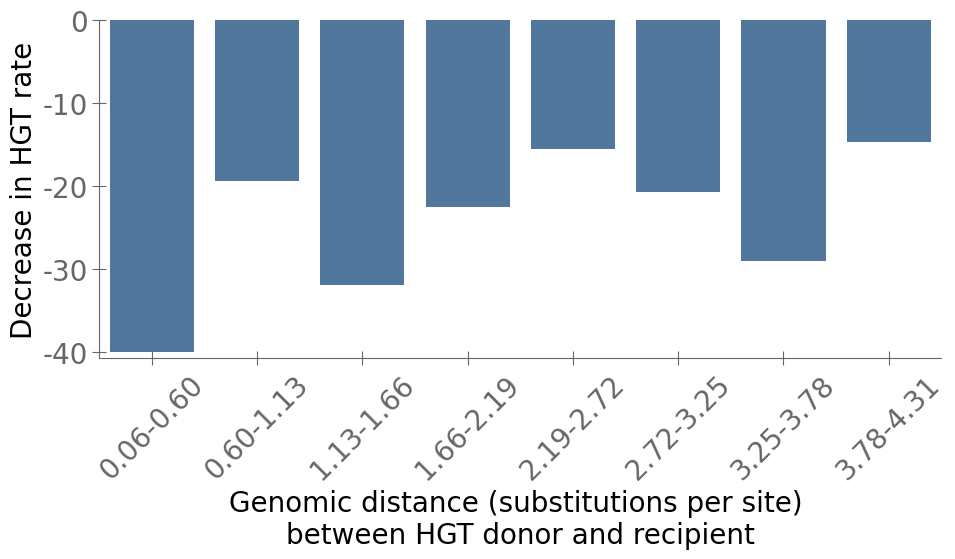

In [6]:
# read in the ecotype transfers

from matplotlib.figure import figaspect


def add_combined_ed_bl_column(combined_ed_bl_filepath, compiled_ale_hgt_df):
    combined_ed_bl_df = pd.read_csv(combined_ed_bl_filepath, sep='\t', header=0)
    compiled_ale_hgt_df["HGT per substitution per site"] = compiled_ale_hgt_df.apply(
        lambda row: combined_ed_bl_df[
            combined_ed_bl_df["Branch"] == row["recipient_branch"]
        ]["Gene Transfers/Branch Length"].values[0],
        axis=1,
    )
    compiled_ale_hgt_df['ecotype_transfers'] = compiled_ale_hgt_df.apply(
        lambda row: combined_ed_bl_df[combined_ed_bl_df['Branch'] == row['recipient_branch']]['Ecosystem Transfers'].values[0],
        axis=1
    )
    compiled_ale_hgt_df['branch_length'] = compiled_ale_hgt_df.apply(
        lambda row: combined_ed_bl_df[combined_ed_bl_df['Branch'] == row['recipient_branch']]['Branch Length'].values[0],
        axis=1
    )
    return compiled_ale_hgt_df


def perform_randomisation_test(args):
    genomic_distance, this_subset_df = args
    # perform a randomisation test to determine if the difference in HGT rates between
    # zero ecotype transfers and non-zero ecotype transfers is significant
    # by randomly shuffling the ecotype_transfers column and calculating the difference in mean HGT rates
    # between the two groups
    zero_ed_hgt_df = this_subset_df[this_subset_df['ecotype_transfers'] == 0]
    nonzero_ed_hgt_df = this_subset_df[this_subset_df['ecotype_transfers'] > 0]
    # in each of these dfs, group by recipient_branch and take the sum of HGT per substitution per site
    if len(zero_ed_hgt_df) == 0 or len(nonzero_ed_hgt_df) == 0:
        print(f"Genomic distance: {genomic_distance}, zero ED transfer branches: {len(zero_ed_hgt_df)}, nonzero ED transfer branches: {len(nonzero_ed_hgt_df)}")
        # return 1, 0, genomic_distance
        zero_ed_mean_hgt = np.nan if len(zero_ed_hgt_df) == 0 else zero_ed_hgt_df['HGT per substitution per site'].mean()
        nonzero_ed_mean_hgt = np.nan if len(nonzero_ed_hgt_df) == 0 else nonzero_ed_hgt_df['HGT per substitution per site'].mean()
        return (np.nan,
                np.nan,
                genomic_distance, 
                zero_ed_mean_hgt, 
                nonzero_ed_mean_hgt,
                np.nan,
                np.nan)
        # return None
    observed_diff = (
        nonzero_ed_hgt_df["HGT per substitution per site"].mean()
        - zero_ed_hgt_df["HGT per substitution per site"].mean()
    )

    num_randomisations = 1e4
    randomisation_diffs = []
    for randomisation in range(int(num_randomisations)):
        randomised_df = pd.concat([zero_ed_hgt_df, nonzero_ed_hgt_df])
        randomised_df['ecotype_transfers'] = np.random.permutation(randomised_df['ecotype_transfers'].values)
        random_zero_ed_hgt_df = randomised_df[randomised_df['ecotype_transfers'] == 0]
        random_nonzero_ed_hgt_df = randomised_df[randomised_df['ecotype_transfers'] > 0]
        randomisation_diffs.append(
            random_nonzero_ed_hgt_df["HGT per substitution per site"].mean()
            - random_zero_ed_hgt_df["HGT per substitution per site"].mean()
        )

    # two-tailed p-value of the observed difference being due to chance
    # +1 on numerator and denominator for continuity correction
    p_value = (np.sum(np.abs(randomisation_diffs) >= np.abs(observed_diff)) + 1) / (num_randomisations + 1)

    ci_lower = np.percentile(randomisation_diffs, 2.5)
    ci_upper = np.percentile(randomisation_diffs, 97.5)

    # print(f"Genomic distance: {genomic_distance}, p-value: {p_value}, observed difference: {observed_diff}")
    # display(zero_ed_hgt_df)
    # display(nonzero_ed_hgt_df)
    return (p_value, 
            observed_diff, 
            genomic_distance, 
            zero_ed_hgt_df['HGT per substitution per site'].mean(), 
            nonzero_ed_hgt_df['HGT per substitution per site'].mean(),
            ci_lower,
            ci_upper)


def plot_genomic_distance_vs_transfer_difference(compiled_ale_hgt_df, comparison='min'):
    import multiprocessing as mp
    # at increasing genomic distances, plot the difference between transfers
    # in two branch sets: branches with zero ecotype_transfers and branches with non-zero ecotype_transfers
    # along with a randomisation test
    transfer_rate_diff_list = []
    min_genomic_distance = compiled_ale_hgt_df['genomic_distance'].min()
    max_genomic_distance = compiled_ale_hgt_df['genomic_distance'].max()
    num_distances = 21
    if comparison == 'min':
        with mp.Pool(processes=num_distances) as pool:
            for result in tqdm(
                pool.imap_unordered(perform_randomisation_test, [(genomic_distance,
                    compiled_ale_hgt_df[
                        # only consider genomic distances at least as large as the current genomic_distance
                        (compiled_ale_hgt_df['genomic_distance'] <= genomic_distance)
                    ])
                    for genomic_distance in np.linspace(min_genomic_distance, max_genomic_distance, num_distances)
                ]),
                total=num_distances,
                desc="Performing randomisation tests across genomic distances",
            ):
                if result is not None:
                    p_value, observed_diff, genomic_distance_res, zero_ed_mean, nonzero_ed_mean, cil, ciu = result
                    transfer_rate_diff_list.append({
                        'genomic_distance': genomic_distance_res,
                        'transfer_rate_diff': observed_diff,
                        'p_value': p_value,
                        'zero_ed_mean_hgt': zero_ed_mean,
                        'nonzero_ed_mean_hgt': nonzero_ed_mean,
                        'ci_lower': cil,
                        'ci_upper': ciu,
                        'num_branches': len(compiled_ale_hgt_df[compiled_ale_hgt_df['genomic_distance'] <= genomic_distance_res]),
                        'num_zero_ed_branches': len(compiled_ale_hgt_df[
                                                        (compiled_ale_hgt_df['genomic_distance'] <= genomic_distance_res) &
                                                        (compiled_ale_hgt_df['ecotype_transfers'] == 0)
                                                    ]),
                        'num_nonzero_ed_branches': len(compiled_ale_hgt_df[
                                                        (compiled_ale_hgt_df['genomic_distance'] <= genomic_distance_res) &
                                                        (compiled_ale_hgt_df['ecotype_transfers'] > 0)
                                                    ]),
                    })

        transfer_rate_diff_df = pd.DataFrame(transfer_rate_diff_list)
        # perform FDR correction on a copy of the dataframe since there are rows where p-value is NaN
        transfer_rate_diff_df_copy = transfer_rate_diff_df[transfer_rate_diff_df['p_value'].notnull()].copy()
        transfer_rate_diff_df_copy['FDR corrected p_value'] = stats.false_discovery_control(transfer_rate_diff_df_copy['p_value'])
        transfer_rate_diff_df['FDR corrected p_value'] = np.nan
        transfer_rate_diff_df.loc[transfer_rate_diff_df_copy.index, 'FDR corrected p_value'] = transfer_rate_diff_df_copy['FDR corrected p_value']

        transfer_rate_diff_df['p_value_bool'] = transfer_rate_diff_df['p_value'] < 0.05
        display(transfer_rate_diff_df)

        # plot scatterplot of transfer rate difference vs genomic distance
        # gray out points with non-significant p-values
        sns.scatterplot(
            data=transfer_rate_diff_df[transfer_rate_diff_df['p_value_bool'].notnull()],
            x='genomic_distance',
            y='transfer_rate_diff',
            hue='p_value_bool',
            palette={True: 'blue', False: 'gray'},
        )
        plt.xlabel('Max. genomic distance (substitutions per site) \nbetween HGT donor and recipient')
        plt.ylabel('Decrease in HGT rate')
        plt.legend(
            title='p-value < 0.05',
            loc='best',
        )
        # gridlines
        plt.grid(True)
        plt.show()
    elif comparison == 'bin':
        # same as above, but instead of considering all genomic distances below a certain threshold, bin them
        # and calculate the mean difference in transfer rates for each bin, performing a randomisation test, and plotting

        # bin the genomic distances
        num_bins = 10
        genomic_distance_bins = np.linspace(min_genomic_distance, max_genomic_distance, num_bins)
        # labels corresponding to the max genomic distance in each bin
        genomic_distance_bin_labels = [
            f"{genomic_distance:.2f}-{genomic_distance2:.2f}"
            for genomic_distance, genomic_distance2 in zip(
                genomic_distance_bins[:-1], genomic_distance_bins[1:]
            )
        ]
        compiled_ale_hgt_df['genomic_distance_bin'] = pd.cut(
            compiled_ale_hgt_df['genomic_distance'],
            bins=genomic_distance_bins,
            labels=genomic_distance_bin_labels,
            right=False,
        )

        transfer_rate_diff_list = []
        with mp.Pool(processes=num_bins) as pool:
            for result in tqdm(
                pool.imap_unordered(perform_randomisation_test, [(genomic_distance,
                    compiled_ale_hgt_df[
                        (compiled_ale_hgt_df['genomic_distance_bin'] == genomic_distance)
                    ])
                    for genomic_distance in genomic_distance_bin_labels
                ]),
                total=num_bins,
                desc="Performing randomisation tests across genomic distance bins",
            ):
                if result is None:
                    continue
                p_value, observed_diff, genomic_distance_res, zero_ed_mean, nonzero_ed_mean, cil, ciu = result
                transfer_rate_diff_list.append({
                    'genomic_distance': genomic_distance_res,
                    'transfer_rate_diff': observed_diff,
                    'p_value': p_value,
                    'zero_ed_mean_hgt': zero_ed_mean,
                    'nonzero_ed_mean_hgt': nonzero_ed_mean,
                    'ci_lower': cil,
                    'ci_upper': ciu,
                    'num_branches': len(compiled_ale_hgt_df[compiled_ale_hgt_df['genomic_distance_bin'] == genomic_distance_res]),
                    'num_zero_ed_branches': len(compiled_ale_hgt_df[
                                                    (compiled_ale_hgt_df['genomic_distance_bin'] == genomic_distance_res) &
                                                    (compiled_ale_hgt_df['ecotype_transfers'] == 0)
                                                ]),
                    'num_nonzero_ed_branches': len(compiled_ale_hgt_df[
                                                    (compiled_ale_hgt_df['genomic_distance_bin'] == genomic_distance_res) &
                                                    (compiled_ale_hgt_df['ecotype_transfers'] > 0)
                                                ]),
                })

        transfer_rate_diff_df = pd.DataFrame(transfer_rate_diff_list)
        # perform FDR correction on a copy of the dataframe since there are rows where p-value is NaN
        transfer_rate_diff_df_copy = transfer_rate_diff_df[transfer_rate_diff_df['p_value'].notnull()].copy()
        transfer_rate_diff_df_copy['FDR corrected p_value'] = stats.false_discovery_control(transfer_rate_diff_df_copy['p_value'])
        transfer_rate_diff_df['FDR corrected p_value'] = np.nan
        transfer_rate_diff_df.loc[transfer_rate_diff_df_copy.index, 'FDR corrected p_value'] = transfer_rate_diff_df_copy['FDR corrected p_value']

        transfer_rate_diff_df['p_value_bool'] = transfer_rate_diff_df['p_value'] < 0.05

        # sort by distance
        transfer_rate_diff_df = transfer_rate_diff_df.sort_values('genomic_distance')

        display(transfer_rate_diff_df)
        latex_out_df = transfer_rate_diff_df.copy()
        # keep only relevant columns
        latex_out_df = latex_out_df[
            [
                "genomic_distance",
                "nonzero_ed_mean_hgt",
                "zero_ed_mean_hgt",
                "transfer_rate_diff",
                "FDR corrected p_value",
            ]
        ]
        # rename columns
        latex_out_df.columns = [
            "Genomic distance",
            "Nonzero ED mean HGT rate",
            "Zero ED mean HGT rate",
            "Decrease in HGT rate",
            "FDR corrected p-value",
        ]
        # replace nan values with 'NA'
        latex_out_df = latex_out_df.fillna('NA')
        # print to latex
        print(latex_out_df.to_latex(index=False, float_format="%.4f"))

        # plot barplot of transfer rate difference vs genomic distance bin
        # gray out bars with p-values > 0.05
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(
            data=transfer_rate_diff_df[transfer_rate_diff_df['FDR corrected p_value'].notnull()],
            x="genomic_distance",
            y="transfer_rate_diff",
            # hue="p_value_bool",
            # palette={True: "blue", False: "gray"},
            ax=ax,
        )
        # annotate the bars with the number of branches in each bin, i.e. 'x\ny' for y branches in total, x with max of zero ecotype transfers and non-zero ecotype transfers
        # for index, row in transfer_rate_diff_df.iterrows():
        #     plt.text(
        #         row['genomic_distance'],
        #         row['transfer_rate_diff'],
        #         f"{row[['num_zero_ed_branches', 'num_nonzero_ed_branches']].max()}\n{row['num_branches']}",
        #         ha='center',
        #         va='bottom',
        #         fontsize=6,
        #     )
        # print(f"The annotated numbers are:\ntop: number of branches of either branch set, whichever is larger\nbottom: total number of branches in the bin")

        plt.xlabel('Genomic distance (substitutions per site) \nbetween HGT donor and recipient')
        plt.ylabel('Decrease in HGT rate')
        plt.xticks(rotation=45)
        # plt.legend(
        #     title='p-value < 0.05',
        #     loc='best',
        # )
        # tight layout
        plt.tight_layout()

        # save to png
        plt.savefig(f"../data/plots/genomic_distance_vs_transfer_difference_{comparison}s.png")

        plt.show()


combined_ed_bl_filepath = (
    # gene method: ALE, ecotype method: Count
    "../data/stats/all/combined_df-all-gene.ale-ecotype.count.tsv"
)
compiled_ale_hgt_df = add_combined_ed_bl_column(
    combined_ed_bl_filepath, compiled_ale_hgt_df
)

# plot_genomic_distance_vs_transfer_difference(compiled_ale_hgt_df, comparison='min')

plot_genomic_distance_vs_transfer_difference(compiled_ale_hgt_df, comparison='bin')